#### **Library imports**

In [2]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Hyperparams and loading data**

In [1]:
dataset = 'steam'

train_edges = np.load(dataset + '/train_edges.npy')
user_list = train_edges[:, 0]
item_list = train_edges[:, 1]
rating_list = train_edges[:, 2].astype('float32')

n_users = user_list.max() + 1 
n_items = item_list.max() + 1
n_samples = len(rating_list)

n_users, n_items, n_samples

<IPython.core.display.Javascript object>

(1698, 1397, 168848)

#### **Defining collaborative filtering**

In [23]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

In [92]:
class NCF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.fc1 = nn.Linear(n_factors * 2, n_factors)
        self.fc2 = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()
        swish = nn.SiLU()

        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.concat([u, i], dim = 1)
        x = swish(x)
        x = self.fc1(x)
        x = swish(x)
        x = self.fc2(x)
        x = sigmoid(x)
        return x

In [93]:
def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Code for surrogate meta-attack (surrogate-CF-SGD, evaluation-CF-Adam, same-init)**

In [111]:
# model settings
surrogate = 'NCF(swish)'
target = 'NCF(swish)'
opt_surrogate = 'adam'
opt_target = 'adam'
lr_surrogate = 0.01
lr_target = 0.01
seed_surrogate = 50
seed_target = 0

# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
T = 250
Delta = 5000 # 5% ~ 10K perturbations
n_factors = 64
save_results = True
retain_graph = True 
create_graph = False

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
perturbations['accuracy_before'] = []
perturbations['accuracy_after'] = []
perturbations['loss_before'] = []
perturbations['loss_after'] = []

perturbations['accuracy_before_eval'] = []
perturbations['accuracy_after_eval'] = []
perturbations['loss_before_eval'] = []
perturbations['loss_after_eval'] = []

# print hyperparam config
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
print()
print('-> Surrogate: ', surrogate)
print('-> Target: ', target)
print('-> Surrogate optimizer: ', opt_surrogate)
print('-> Target optimizer: ', opt_target)
print('-> Surrogate learning rate: ', lr_surrogate)
print('-> Target learning rate: ', lr_target)
print('-> Surrogate seed: ', seed_surrogate)
print('-> Target seed: ', seed_target)
print()
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)
if 'NCF' in surrogate:
    ratings = ratings.reshape((n_samples, 1))
perturbs = torch.ones_like(ratings).bool()

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # define model and it's parameters
    if 'NCF' in surrogate:
        model = NCF(n_users, n_items, n_factors)
    else:
        model = CollaborativeFiltering(n_users, n_items, n_factors)
    model.to(device)

    # reset model paramters 
    torch.manual_seed(seed_surrogate)
    for layer in model.children():
        layer.reset_parameters()

    # define optimizer
    if 'adam' in opt_surrogate:
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_surrogate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr = lr_surrogate)
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    # inner loop training process
    model.train()
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)

        # use torch.optim optimizer to compute gradients
        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # compute training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy_before'].append(get_accuracy(y_hat, ratings))
        perturbations['loss_before'].append(loss_fn(y_hat, ratings).item())

        # compute training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy_after'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after'].append(loss_fn(y_hat_masked, ratings_masked).item())
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # define evaluation model
    if 'NCF' in target:
        eval_model = NCF(n_users, n_items, n_factors)
    else:
        eval_model = CollaborativeFiltering(n_users, n_items, n_factors)
    eval_model.to(device)

    # reset eval model parameters
    torch.manual_seed(seed_target)
    for layer in eval_model.children():
        layer.reset_parameters()

    # define optimizer_eval
    if 'adam' in opt_target:
        optimizer_eval = torch.optim.Adam(eval_model.parameters(), lr = lr_target)
    else:
        optimizer_eval = torch.optim.SGD(eval_model.parameters(), lr = lr_target)
    
    # define loss function
    loss_fn_eval = nn.BCELoss(reduction = 'mean')

    # detach ratings and perturbs for eval model
    ratings_eval = ratings.detach().clone()
    perturbs_eval = perturbs.detach().clone()

    # reshape ratings and perturbs if necessary
    if surrogate != target:
        if 'NCF' in target:
            ratings_eval = ratings_eval.reshape((n_samples, 1))
            perturbs_eval = perturbs_eval.reshape((n_samples, 1))
        else:
            ratings_eval = ratings_eval.reshape((n_samples))
            perturbs_eval = perturbs_eval.reshape((n_samples))

    # inner train  evaluation model
    eval_model.train()
    for i in range(T):
        y_hat = eval_model(users, items)
        loss_eval = loss_fn_eval(y_hat, ratings_eval)

        # use torch.optim optimizer to compute gradients
        optimizer_eval.zero_grad()
        loss_eval.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer_eval.step()
    
    eval_model.eval()

    # compute and store accuracy of eval model after T training steps
    with torch.no_grad():
        # compute training accuracy and loss including perturbed edges
        y_hat = eval_model(users, items)
        perturbations['accuracy_before_eval'].append(get_accuracy(y_hat, ratings_eval))
        perturbations['loss_before_eval'].append(loss_fn_eval(y_hat, ratings_eval).item())

        # compute training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs_eval)
        ratings_masked = torch.masked_select(ratings_eval, perturbs_eval)
        perturbations['accuracy_after_eval'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after_eval'].append(loss_fn_eval(y_hat_masked, ratings_masked).item())

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1
        perturbs[best_edge] = False

        # keep track of perturbations and accuracy
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
perturbations = pd.DataFrame(perturbations)
filename = 'surrogate{}-target{}-meta-Delta={}-T={}-diffinit'.format(surrogate, target, Delta, T)

# save results in CSV format
if save_results:
    perturbations.to_csv('results/' + dataset + '/' + filename + '.csv')

-> T:  250
-> Delta: 5000 (2.96%)
-> Embedding size:  64
-> Device:  cuda:6

-> Surrogate:  NCF(swish)
-> Target:  NCF(swish)
-> Surrogate optimizer:  adam
-> Target optimizer:  adam
-> Surrogate learning rate:  0.01
-> Target learning rate:  0.01
-> Surrogate seed:  50
-> Target seed:  0

-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 5000/5000 [2:16:17<00:00,  1.64s/it]  


-> Execution time: 02h 16m 18s


In [114]:
perturbations

,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after,accuracy_before_eval,accuracy_after_eval,loss_before_eval,loss_after_eval
0,3641,0.000304,0.944992,0.944992,0.155346,0.155346,0.963292,0.963292,0.118882,0.118882
1,49526,0.000283,0.943890,0.943890,0.160610,0.160611,0.951714,0.951714,0.137681,0.137682
2,101502,0.000258,0.941456,0.941456,0.165901,0.165899,0.958045,0.958045,0.128989,0.128990
3,123489,0.000270,0.946141,0.946140,0.154077,0.154077,0.959360,0.959359,0.126799,0.126800
4,12088,0.000247,0.945999,0.945997,0.155850,0.155849,0.958667,0.958666,0.123948,0.123949
...,...,...,...,...,...,...,...,...,...,...
4995,21913,0.000092,0.942753,0.944627,0.173264,0.167774,0.923174,0.923248,0.202342,0.201440
4996,87765,0.000085,0.938892,0.943199,0.178706,0.168361,0.930914,0.932848,0.192149,0.187015
4997,128890,0.000105,0.945809,0.948868,0.167478,0.159379,0.931779,0.932500,0.190562,0.188032
4998,91301,0.000092,0.947142,0.949179,0.164561,0.158878,0.935706,0.936717,0.183268,0.180127


In [116]:
perturbations[::200]

,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after,accuracy_before_eval,accuracy_after_eval,loss_before_eval,loss_after_eval
0,3641,0.000304,0.944992,0.944992,0.155346,0.155346,0.963292,0.963292,0.118882,0.118882
200,47257,0.000133,0.941308,0.941452,0.166592,0.166071,0.956677,0.956649,0.128567,0.128602
400,128273,0.000117,0.941054,0.941406,0.167762,0.166751,0.956796,0.956841,0.129803,0.129500
600,15431,0.000107,0.941581,0.942157,0.169079,0.167250,0.959028,0.959096,0.128551,0.128087
800,45364,0.000097,0.938063,0.938803,0.175346,0.173017,0.955037,0.955031,0.136632,0.136291
1000,43189,0.000094,0.934361,0.935174,0.183250,0.180340,0.949505,0.949883,0.147567,0.146299
1200,96986,0.000087,0.933005,0.935543,0.183766,0.177377,0.947995,0.948374,0.151838,0.150492
1400,36,0.000089,0.937305,0.939414,0.180585,0.174769,0.950364,0.950576,0.149243,0.148273
1600,114589,0.000080,0.931554,0.934451,0.192369,0.184817,0.949730,0.950230,0.148219,0.146389
1800,152371,0.000082,0.929203,0.930984,0.197017,0.191448,0.939129,0.939257,0.168414,0.167424


In [113]:
perturbations.metagrad.max()

0.00030420697294175625

#### **Plots**

In [117]:
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)']
perturbations_reset

,# Perturbations,Perturbed edge,Meta gradient,Accuracy including perturbed edges (surrogate),Accuracy excluding perturbed edges (surrogate),Loss including perturbed edges (surrogate),Loss excluding perturbed edges (surrogate),Accuracy including perturbed edges (target),Accuracy excluding perturbed edges (target),Loss including perturbed edges (target),Loss excluding perturbed edges (target)
0,0,3641,0.000304,0.944992,0.944992,0.155346,0.155346,0.963292,0.963292,0.118882,0.118882
1,1,49526,0.000283,0.943890,0.943890,0.160610,0.160611,0.951714,0.951714,0.137681,0.137682
2,2,101502,0.000258,0.941456,0.941456,0.165901,0.165899,0.958045,0.958045,0.128989,0.128990
3,3,123489,0.000270,0.946141,0.946140,0.154077,0.154077,0.959360,0.959359,0.126799,0.126800
4,4,12088,0.000247,0.945999,0.945997,0.155850,0.155849,0.958667,0.958666,0.123948,0.123949
...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,21913,0.000092,0.942753,0.944627,0.173264,0.167774,0.923174,0.923248,0.202342,0.201440
4996,4996,87765,0.000085,0.938892,0.943199,0.178706,0.168361,0.930914,0.932848,0.192149,0.187015
4997,4997,128890,0.000105,0.945809,0.948868,0.167478,0.159379,0.931779,0.932500,0.190562,0.188032
4998,4998,91301,0.000092,0.947142,0.949179,0.164561,0.158878,0.935706,0.936717,0.183268,0.180127


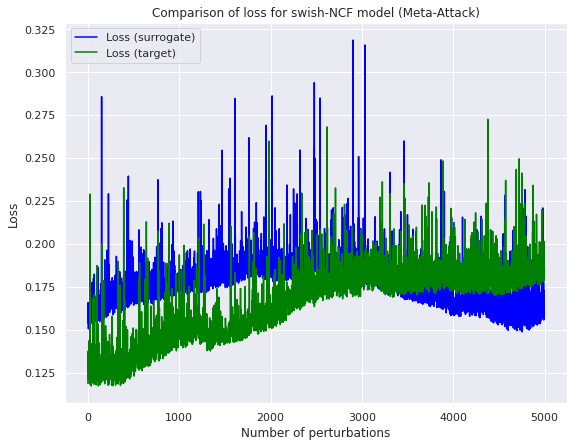

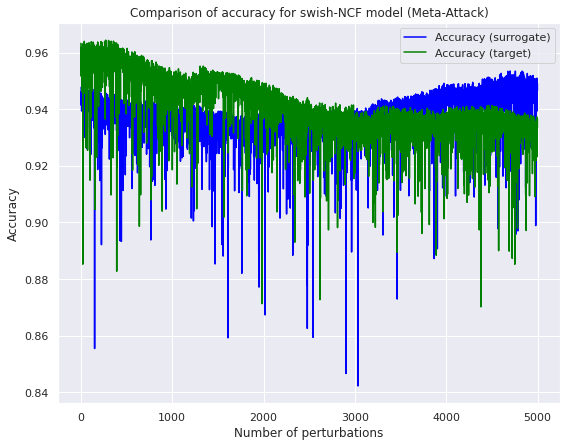

In [122]:
sns.set_theme()
figsize = (9, 7)

# Loss plot

plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss for swish-NCF model (Meta-Attack)')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'], loc = 'upper left')
fig.savefig('plots/losses_' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy for swish-NCF model (Meta-Attack)')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
fig.savefig('plots/accuracy_' + filename)
plt.show()